In [1]:
import h5py
import numpy as np
from synthesizer.conversions import lnu_to_absolute_mag
import pandas as pd
import matplotlib.pyplot as plt
import unyt
from unyt import erg, Hz, s, unyt_quantity
import os
import sys
sys.path.append("/disk/xray15/aem2/camels/proj2")
from setup_params_alice import get_luminosity_function, get_colour_distribution
from variables_config_SB import (
    redshift_values, lf_data_dir,
    colour_data_dir, uvlf_limits, uvlf_nbins, colour_limits,
    colour_nbins, mag_limits, colour_pairs, filters
)

# safe name for passing in and using for naming paths/directories without underscores.  see more below (get_colour_dir_name)
def get_safe_name(name, filter_system_only=False):
    """
    Convert string to path-safe version and/or extract filter system.
    """
    safe_name = name.replace(' ', '_')
    if filter_system_only:
        return safe_name.split('_')[0]
    return safe_name

# uses the above function to handle the colour directory name, without too many underscores and repeated words
# e.g. instead of GALEX_FUV-GALEX_NUV its just GALEX_FUN-NUV
def get_colour_dir_name(band1, band2):
    """
    Create a standardized directory name for colour plots.
    """
    if ' ' in band1:
        system1, filter1 = band1.split(' ', 1)
    else:
        system1, filter1 = band1, band1

    if ' ' in band2:
        system2, filter2 = band2.split(' ', 1)
    else:
        system2, filter2 = band2, band2
        
    if system1 == system2:
        return f"{get_safe_name(system1)}_{filter1}-{filter2}"
    else:
        return f"{get_safe_name(band1)}-{get_safe_name(band2)}"

# get the mask from the magnitude limits to pass into the get_colour_distribution function in setup_params.py (or setup_params_alice.py)
def get_magnitude_mask(photo, filters, mag_limits=None):
    """
    Create a magnitude mask based on provided limits.
    """
    if not mag_limits:
        return None
        
    combined_mask = np.ones(len(photo[filters[0]]), dtype=bool)
    for band in filters:
        if band in mag_limits:
            combined_mask &= (photo[band] < mag_limits[band])
    return combined_mask

# get photometry from SB chris file specifically.
def get_photometry(group_num, spec_type, snap, filters):
    """
    Get photometry data from HDF5 file for a specific group and snapshot
    """
    photo_file = "/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/photometry/alice_galex.h5"
    sim_name = f"SB28_{group_num}"
    photo = {}
    
    try:
        with h5py.File(photo_file, "r") as hf:
            for filt in filters:
                dataset_path = f"{sim_name}/snap_{snap}/BC03/photometry/luminosity/{spec_type}/{filt}"
                
                if dataset_path in hf:
                    photo[filt] = hf[dataset_path][:]
                    photo[filt] *= unyt_quantity.from_string("1 erg/s/Hz")
                    photo[filt] = lnu_to_absolute_mag(photo[filt])
                else:
                    print(f"Warning: Dataset {dataset_path} not found")
                    return None
                    
    except Exception as e:
        print(f"Error reading photometry for {sim_name}: {e}")
        return None
        
    return photo


In [2]:
def process_data(category, bands, colour_pairs=None, mag_limits=None, start_group=0, end_group=49, redshift_dict=None):
    """Process data for any combination of bands and color pairs"""
    # use provided redshift dictionary or fall back to the config one
    redshift_dict = redshift_test or redshift_values
    
    successful_groups = []
    failed_groups = []
    
    for group_num in range(start_group, end_group + 1):
        sim_name = f"SB28_{group_num}"
        print(f"\nProcessing {sim_name}")
        
        group_success = True
        for snap, redshift_info in redshift_dict.items():
            print(f"  Processing z={redshift_info['label']}")
            
            # get photometry
            photo = get_photometry(
                group_num=group_num,
                spec_type="intrinsic" if category == "intrinsic" else "attenuated",
                snap=snap,
                filters=bands
            )
            
            if photo is None:
                print(f"    Skipping {sim_name} due to missing or invalid photometry data")
                group_success = False
                continue

            try:
                # get UVLFs
                for band in bands:
                    phi, phi_sigma, hist, bin_lims = get_luminosity_function(
                        photo,
                        band,
                        *uvlf_limits,
                        n_bins=uvlf_nbins
                    )
                    
                    filter_system = get_safe_name(band, filter_system_only=True)
                    output_dir = os.path.join(lf_data_dir[category][filter_system], 
                                            get_safe_name(redshift_info['label']))
                    os.makedirs(output_dir, exist_ok=True)
                    
                    # save UVLF as txt
                    bin_centers = 0.5 * (bin_lims[1:] + bin_lims[:-1])
                    uvlf_df = pd.DataFrame({
                        'magnitude': bin_centers,
                        'phi': phi,
                        'phi_sigma': phi_sigma,
                        'hist': hist
                    })
                    
                    uvlf_filename = f"UVLF_{sim_name}_{get_safe_name(band)}_{get_safe_name(redshift_info['label'])}_{category}.txt"
                    uvlf_df.to_csv(os.path.join(output_dir, uvlf_filename), 
                                 index=False, sep='\t')
                
                # get colours if pairs provided
                if colour_pairs:
                    for band1, band2 in colour_pairs:
                        if band1 in photo and band2 in photo:
                            mask = get_magnitude_mask(photo, [band1, band2], mag_limits)
                            
                            colour_dist, bin_lims = get_colour_distribution(
                                photo,
                                band1,
                                band2,
                                *colour_limits,
                                n_bins=colour_nbins,
                                mask=mask
                            )
                            
                            filter_system = get_colour_dir_name(band1, band2)
                            output_dir = os.path.join(colour_data_dir[category][filter_system], 
                                                    get_safe_name(redshift_info['label']))
                            os.makedirs(output_dir, exist_ok=True)
                            
                            bin_centers = 0.5 * (bin_lims[1:] + bin_lims[:-1])
                            colour_df = pd.DataFrame({
                                'colour': bin_centers,
                                'distribution': colour_dist
                            })
                            
                            colour_filename = f"Colour_{sim_name}_{filter_system}_{get_safe_name(redshift_info['label'])}_{category}.txt"
                            colour_df.to_csv(os.path.join(output_dir, colour_filename),
                                           index=False, sep='\t')
            
            except Exception as e:
                print(f"    Error processing data for {sim_name}: {e}")
                group_success = False
                continue
            
            print(f"    Completed processing for z={redshift_info['label']}")
        
        if group_success:
            successful_groups.append(group_num)
        else:
            failed_groups.append(group_num)
    
    return {
        'successful': successful_groups,
        'failed': failed_groups
    }

In [3]:
def process_all_data(start_group=0, end_group=49, redshift_dict=None):
    """Process all combinations of data types and bands"""
    results = {}
    
    # Process each category (attenuated/intrinsic) with its specified filters
    for category, category_filters in filters.items():
        # Group filters by type for clearer output
        galex_filters = [f for f in category_filters if "GALEX" in f]
        uv_filters = [f for f in category_filters if "UV" in f and "GALEX" not in f]
        
        if galex_filters:
            print(f"\nProcessing {category} GALEX filters {galex_filters} (groups {start_group}-{end_group})...")
            results[f'{category}_galex'] = process_data(
                category, 
                galex_filters,
                colour_pairs, 
                mag_limits,
                start_group, 
                end_group, 
                redshift_dict
            )
        
        if uv_filters:
            print(f"\nProcessing {category} UV filters {uv_filters} (groups {start_group}-{end_group})...")
            results[f'{category}_uv'] = process_data(
                category, 
                uv_filters,
                None,  # No color pairs for UV-only filters
                mag_limits,
                start_group, 
                end_group, 
                redshift_dict
            )
    
    return results



# Example usage:
if __name__ == "__main__":
    '''
    # Process ALL redshifts from config
    results = process_all_data(
        start_group=0, 
        end_group=49
        # Not passing redshift_dict will use config redshift_values
    )
    '''
    # define test redshift for single snapshot testing/only one available currently
    redshift_test = {
        '044': {'redshift': 2.00, 'label': 'z2.0'}
    }
    all = 2047
    results = process_all_data(
        start_group=0, 
        end_group=all, # 49 for testing
        redshift_dict=redshift_test
    )


Processing intrinsic GALEX filters ['GALEX FUV', 'GALEX NUV'] (groups 0-2047)...

Processing SB28_0
  Processing z=z2.0
    Completed processing for z=z2.0

Processing SB28_1
  Processing z=z2.0
    Completed processing for z=z2.0

Processing SB28_2
  Processing z=z2.0
    Completed processing for z=z2.0

Processing SB28_3
  Processing z=z2.0
    Completed processing for z=z2.0

Processing SB28_4
  Processing z=z2.0
    Completed processing for z=z2.0

Processing SB28_5
  Processing z=z2.0
    Completed processing for z=z2.0

Processing SB28_6
  Processing z=z2.0
    Completed processing for z=z2.0

Processing SB28_7
  Processing z=z2.0
    Completed processing for z=z2.0

Processing SB28_8
  Processing z=z2.0
    Completed processing for z=z2.0

Processing SB28_9
  Processing z=z2.0
    Completed processing for z=z2.0

Processing SB28_10
  Processing z=z2.0
    Completed processing for z=z2.0

Processing SB28_11
  Processing z=z2.0
    Completed processing for z=z2.0

Processing SB28

TEST FOR PLOTTING SOME SB SET DATA

In [14]:
def plot_sb28_data(sim_name=None, group_num=None, redshift_dict=None, filters_to_plot=None, colour_pairs=None):
    """
    Create plots showing both intrinsic and attenuated data for all redshifts
    
    Args:
        sim_name (str, optional): Full simulation name (if None, will be constructed from group_num)
        group_num (int, optional): SB28 group number (if sim_name not provided)
        redshift_dict (dict): Dictionary containing all redshift/snapshot information
        filters_to_plot (list): Specific filters to plot
        colour_pairs (list): Specific colour pairs to plot
    """
    # Validate inputs
    if sim_name is None and group_num is not None:
        sim_name = f"SB28_{group_num}"
    elif sim_name is None and group_num is None:
        raise ValueError("Either sim_name or group_num must be provided")
    
    if redshift_dict is None:
        raise ValueError("redshift_dict must be provided")
        
    # Use provided filters or get from config
    filters_to_plot = filters_to_plot or filters["attenuated"]
    colour_pairs = colour_pairs or [("GALEX FUV", "GALEX NUV")]
    
    # Create plots for each redshift
    for snap, redshift_info in redshift_dict.items():
        print(f"\nProcessing {sim_name} at z={redshift_info['label']}...")
        
        # Get intrinsic data
        rest_photo = get_photometry(
            group_num=group_num,
            spec_type="intrinsic",
            snap=snap,
            filters=filters_to_plot
        )
        
        # Get attenuated data
        att_photo = get_photometry(
            group_num=group_num,
            spec_type="attenuated",
            snap=snap,
            filters=filters_to_plot
        )
        
        if rest_photo is None and att_photo is None:
            print(f"No data available for {sim_name} at z={redshift_info['label']}")
            continue
            
        # Calculate UVLFs and colours
        rest_uvlfs = {}
        att_uvlfs = {}
        rest_colours = {}
        att_colours = {}
        
        # Process UVLFs
        for band in filters_to_plot:
            if rest_photo and band in rest_photo:
                phi, phi_sigma, hist, bin_lims = get_luminosity_function(
                    rest_photo,
                    band,
                    *uvlf_limits,
                    n_bins=uvlf_nbins
                )
                rest_uvlfs[band] = (phi, phi_sigma, hist, bin_lims)
                
            if att_photo and band in att_photo:
                phi, phi_sigma, hist, bin_lims = get_luminosity_function(
                    att_photo,
                    band,
                    *uvlf_limits,
                    n_bins=uvlf_nbins
                )
                att_uvlfs[band] = (phi, phi_sigma, hist, bin_lims)
        
        # Process colours
        for band1, band2 in colour_pairs:
            if rest_photo and band1 in rest_photo and band2 in rest_photo:
                mask = get_magnitude_mask(rest_photo, [band1, band2], mag_limits)
                colour_dist, bin_lims = get_colour_distribution(
                    rest_photo,
                    band1,
                    band2,
                    *colour_limits,
                    n_bins=colour_nbins,
                    mask=mask
                )
                color_name = f"{band1}-{band2}"
                rest_colours[color_name] = (colour_dist, bin_lims)
                
            if att_photo and band1 in att_photo and band2 in att_photo:
                mask = get_magnitude_mask(att_photo, [band1, band2], mag_limits)
                colour_dist, bin_lims = get_colour_distribution(
                    att_photo,
                    band1,
                    band2,
                    *colour_limits,
                    n_bins=colour_nbins,
                    mask=mask
                )
                color_name = f"{band1}-{band2}"
                att_colours[color_name] = (colour_dist, bin_lims)
        
        # Create plots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Plot UVLFs
        for band in filters_to_plot:
            # Plot intrinsic UVLFs
            if band in rest_uvlfs:
                phi, phi_sigma, hist, bin_lims = rest_uvlfs[band]
                bin_centers = 0.5 * (bin_lims[1:] + bin_lims[:-1])
                ax1.errorbar(bin_centers, phi, yerr=phi_sigma, 
                            fmt='o-', label=f"{band} (Intrinsic)", capsize=5)
                            
            # Plot attenuated UVLFs
            if band in att_uvlfs:
                phi, phi_sigma, hist, bin_lims = att_uvlfs[band]
                bin_centers = 0.5 * (bin_lims[1:] + bin_lims[:-1])
                ax2.errorbar(bin_centers, phi, yerr=phi_sigma, 
                            fmt='o-', label=f"{band} (Attenuated)", capsize=5)
        
        # Configure UVLF plots
        for ax, title in [(ax1, 'Intrinsic UVLFs'), (ax2, 'Attenuated UVLFs')]:
            #ax.set_ylim(-5, -2.5)
            #ax.set_xlim(*uvlf_limits)
            ax.set_xlabel('Absolute Magnitude (AB)')
            ax.set_ylabel('Number Density (Mpc$^{-3}$ mag$^{-1}$)')
            ax.set_title(f'{title} (z={redshift_info["redshift"]})')
            ax.grid(True, alpha=0.3)
            ax.legend()
        
        # Plot colour distributions
        for color_name, (dist, bins) in rest_colours.items():
            bin_centers = 0.5 * (bins[1:] + bins[:-1])
            ax3.hist(bin_centers, bins=bins, weights=dist,
                    alpha=0.7, color='royalblue', edgecolor='black',
                    label=f"{color_name} (Intrinsic)")
                    
        for color_name, (dist, bins) in att_colours.items():
            bin_centers = 0.5 * (bins[1:] + bins[:-1])
            ax4.hist(bin_centers, bins=bins, weights=dist,
                    alpha=0.7, color='royalblue', edgecolor='black',
                    label=f"{color_name} (Attenuated)")
        
        # Configure colour plots
        for ax, title in [(ax3, 'Intrinsic Colour Distribution'), (ax4, 'Attenuated Colour Distribution')]:
            ax.set_xlabel('Color [mag]')
            ax.set_ylabel('Normalized Count')
            ax.set_title(title)
            ax.grid(True, alpha=0.3)
            ax.legend()
        
        plt.suptitle(f'UVLF and Colour Distributions for {sim_name} at z={redshift_info["redshift"]}', y=1.02)
        plt.tight_layout()
        plt.show()
    
    return {
        'sim_name': sim_name,
        'redshifts_processed': list(redshift_dict.keys())
    }


Processing SB28_999 at z=z2.0...


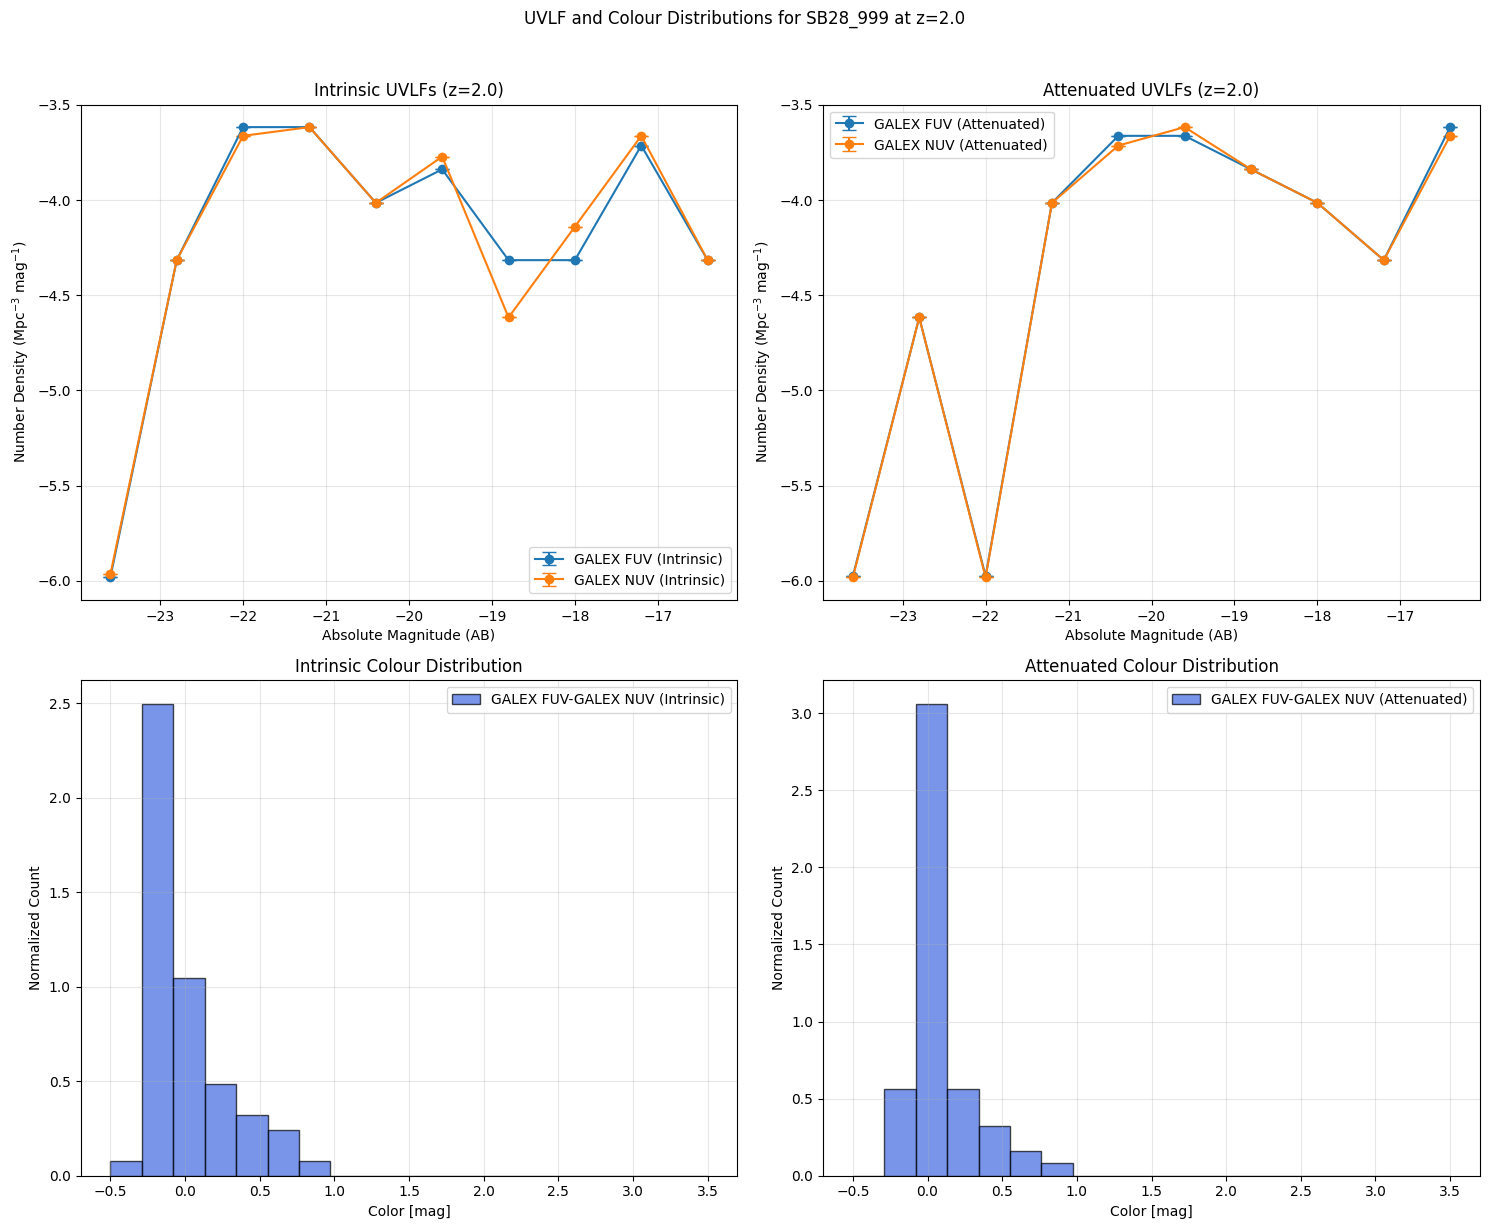

In [16]:
if __name__ == "__main__":
    '''
    # for ALL redshifts
    results = plot_sb28_data(
        group_num=0,
        redshift_dict=redshift_values,  # from config redshift dictionary
        filters_to_plot=["GALEX FUV", "GALEX NUV"],
        colour_pairs=[("GALEX FUV", "GALEX NUV")]
    )
    '''
    
    # Or test with just one redshift
    redshift_test = {'044': {'redshift': 2.00, 'label': 'z2.0'}}
    results = plot_sb28_data(
        group_num=999,
        redshift_dict=redshift_test,
        filters_to_plot=["GALEX FUV", "GALEX NUV"],
        colour_pairs=[("GALEX FUV", "GALEX NUV")]
    )